# RakuPy : modèle de Deep Learning pour la classification de produits d'e-commerce

Nous présentons dans ce notebook un modèle de Deep Learning pour la classification d'articles d'e-commerce à partir du texte (intitulé des produits) et de l'image (une illustration par produit).

Il a été développé et évalué sur un jeu de données concernant 84916 produits classifiés en 27 catégories de tailles variables et fourni par la plateforme de e-commerce Rakuten France. Les données sont librement téléchargeable ici :
https://challengedata.ens.fr/participants/challenges/35/

Sur ces données ce modèle a obtenu pour le jeu de validation un F1-score pondéré de 0.83 et une accuracy de 0.83.

Voici comment est organisé ce notebook :

1. Importations des modules et chargement des données
1. Rognage et redimensionnement des images
1. Preprocessing
1. Générateurs textes+images
1. Création du modèle
1. Entraînement
1. Évaluation

In [1]:
# Vérification de l'activation du GPU
import tensorflow as tf 

if tf.test.gpu_device_name():
    print('GPU détecté par défaut : {}'.format(tf.test.gpu_device_name()))
    device_name = "/GPU:0"
else:
    print("Pas de GPU disponible sur votre machine.")
    device_name = "/device:CPU:0"


2021-10-05 09:51:16.703938: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


GPU détecté par défaut : /device:GPU:0


2021-10-05 09:51:36.844107: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-05 09:51:36.984465: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-10-05 09:51:37.216732: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-05 09:51:37.217678: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:02:00.0 name: NVIDIA GeForce GTX 960M computeCapability: 5.0
coreClock: 1.176GHz coreCount: 5 deviceMemorySize: 3.95GiB deviceMemoryBandwidth: 74.

## Importations des modules et chargement des données

Les données chargées sont la variable cible (fichier y_train.csv) et le fichier X_train.csv qui contient 4 colonnes :
1. designation (le titre du produit)
1. description (la description, non utilisée dans le modèle)
1. imageid
1. productid

Les deux dernières colonnes permettent d'accèder au fichier image du produit

**Le chemin d'accès aux fichiers dépend de celui de l'utilisateur**


In [3]:
# Importation des modules et des fonctions
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import re
import unicodedata

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.tokenize.regexp import RegexpTokenizer
from nltk.corpus import stopwords
from tensorflow.keras import Model, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Embedding 
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Conv2D 
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import EfficientNetB4
from tensorflow.keras import backend as K
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

%matplotlib inline

# Chemin pour accéder aux documents (à changer selon l'utilisateur)
path = '/home/zhx/Documents/Gilles_projets/'

# labels du jeu d'entraînement
target = pd.read_csv(path+'Data/y_train.csv',index_col=0)
target = target["prdtypecode"].astype(str)

# Chargement des données
df = pd.read_csv(path+'Data/textes/X_train.csv',index_col=0)


## Rognage et redimensionnement des images

**La cellule ci-dessous doit être exécutée une fois pour toute.**

Nous transformons les images en rognant les bords blancs, puis en les redimensionnant à la même taille (350,350) plus petite que la dimension originale (500,500).

Ceci permet de réduire le temps de calcul par 2 pour très peu de perte de performance.

**Le chemin d'accès au dossier d'images à transformer et celui du dossier où seront enregistrées les images rognées et redimensionnées sont à adapter selon l'utilisateur**


In [ ]:
import os
from pathlib import Path
from PIL import Image
from matplotlib import image
import cv2
import tqdm

# Chemin d'accès du dossier des images à transformer (à modifier selon l'utilisateur)
Path = path + "Data/images/image_train"

# Chemin d'accès du dossier où seront enregistrées les images rognées et redimensionnées
# (à modifier selon l'utilisateur)
path_crop_resize = "Data/images_resize/image_train/"

# Fonction pour rogner les bords blancs d'une image et la redimensionner à (350,350)
def crop_resize(img):
    # Conversion des images en gris
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Seuil pour définir les zones de blancs
    th, threshed = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY_INV)

    # Effacement du bruit
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    morphed = cv2.morphologyEx(threshed, cv2.MORPH_CLOSE, kernel)

    # Trouver le rectangle optimal
    cnts = cv2.findContours(morphed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2]
    
    # Nous testons si l'image est intégralement blanche
    if len(cnts)==0:
        # Si oui, nous laissons l'image telle quelle
        img_crop = img
    else:
        cnt = sorted(cnts, key=cv2.contourArea)[-1]
        # rognage de l'image
        x,y,w,h = cv2.boundingRect(cnt)
        img_crop = img[y:y+h, x:x+w]
        
    # Redimensionnement de l'image à (350,350)
    img_resize = cv2.resize(img_crop, dsize=(350,350), interpolation=cv2.INTER_CUBIC)
    
    return img_resize

# Nous faisons une boucle sur toutes les images pour les rogner et le redimensionner
for file in tqdm.tqdm(os.listdir(str(Path))):
    # Chargement de l'image
    im = cv2.imread(str(os.path.join(str(Path),file)))
    # Rognage et redimensionnement de l'image
    img = Image.fromarray(crop_resize(im))
    # Sauvegarde de la nouvelle image dans un nouveau dossier
    img.save( path + path_crop_resize +file)

## Preprocessing

Le preprocessing consiste ici à :
1. Incorporer le chemin à chaque image à partir des colonnes 'imageid' et 'productid'
1. Utiliser un tokenizer sur les 10000 mots les plus fréquents pour remplacer les mots par des nombres
1. Compléter par des zéros pour avoir des vecteurs de longueur 34 (le titre le plus long a 34 mots)

Les données sont séparées en un jeu d'entraînement (71104 produits) et en un jeu de validation (13812 produits)

In [ ]:
# Incorporation du chemin de l'image dans le jeu de données
def creation_chemin(col1,col2):
     return path+'Data/images_resize/image_train/image_' + str(col1) + '_product_' + str(col2) + '.jpg'
# Remarque : nous utilisons des images rognées et redimensionnées
df['img_paths'] = np.vectorize(creation_chemin)(df['imageid'],df['productid'])

# Nous séparons les données en un jeu d'entraînement et en un jeu de validation
data_train, data_valid, y_train, y_valid = train_test_split(df,target,test_size=13812,stratify=target,random_state=34)

# on limite à 10000 mots
tokenizer = Tokenizer(num_words=10000)

# On applique le tokenizer sur notre feature designation
tokenizer.fit_on_texts(df.designation)

# On tokenize les datasets X_train et X_valid
X_train = tokenizer.texts_to_sequences(data_train.designation)
X_valid = tokenizer.texts_to_sequences(data_valid.designation)

# Taille du vocabulaire
# on met +1 car le correspond correspond à une absence de mot
vocabulary_size = len(tokenizer.word_index) + 1
X_train = pad_sequences(X_train,padding='post',truncating='post',maxlen=34)
X_valid = pad_sequences(X_valid,padding='post',truncating='post',maxlen=34)


## Générateurs textes+images

Pour utiliser à la fois les textes et les images pour notre modèle, nous avons besoin de créer un générateur qui renverra à la fois le titre et l'image. 

Nous commençons par créer des générateurs d'images. Pour le jeu d'entraînement, le générateur applique des transformations aux images pour montrer à notre modèle des configurations d'images plus variées pour améliorer ses capacités de généralisation.

Ensuite nous créons des générateurs spécialement construits pour notre modèle pour renvoyer les textes avec les images correspondantes.

In [4]:
# Création de générateurs d'images
from tensorflow.keras.applications.efficientnet import preprocess_input
# Pour le jeu d'entraînement (Le générateur d'images du jeu d'entraînement applique 
# des transformations aux images pour augmenter le jeu de données
train_image_data_generator = ImageDataGenerator(preprocessing_function=preprocess_input,rotation_range=5,
                                          width_shift_range=0.05,height_shift_range=0.05,
                                          horizontal_flip=True)
# Pour le jeu de validation
valid_image_data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)


# Taille des batchs
batch_size = 32

data_train["class"] = y_train.astype(str)
data_valid["class"] = y_valid.astype(str)

# Fonction pour créer un générateur images+textes pour le jeu d'entraînement
def trainGenerator(data,X,y,batch_size,seed):
    train_generator_1 = train_image_data_generator.flow_from_dataframe(dataframe=data,
                                                           directory="",
                                                           x_col='img_paths',
                                                           y_col=y,
                                                           class_mode='sparse',
                                                           target_size=(350,350),
                                                           shuffle=False,            
                                                           batch_size=batch_size,
                                                           seed=seed)
    
    i = 0
    
    while True:
        X1 = train_generator_1.next()
        X2 = X[i:(i+batch_size)]
        i+=batch_size
        yield [X1[0], X2], X1[1]
        

# Fonction pour créer un générateur images+textes pour le jeu de validation
def validGenerator(data,X,y,batch_size,seed):
    valid_generator_1 = valid_image_data_generator.flow_from_dataframe(dataframe=data,
                                                           directory="",
                                                           x_col='img_paths',
                                                           y_col=y,
                                                           class_mode='sparse',
                                                           target_size=(350,350),
                                                           shuffle=False,            
                                                           batch_size=batch_size,
                                                           seed=seed)
    
    j = 0
    
    while True:
        X1 = valid_generator_1.next()
        X2 = X[j:(j+batch_size)]
        j+=batch_size
        yield [X1[0], X2], X1[1]


# Pour pouvoir faire plusieurs boucles dans les données de textes lors de l'entraînement
X_train_2 = np.concatenate((X_train,X_train,X_train,X_train,X_train,X_train),axis=0)
X_valid_2 = np.concatenate((X_valid,X_valid,X_valid,X_valid,X_valid,X_valid),axis=0)

# Création des générateurs textes+images
train_generator = trainGenerator(data=data_train,X=X_train_2,y='class',batch_size=batch_size,seed=123)
valid_generator = validGenerator(data=data_valid,X=X_valid_2,y='class',batch_size=1,seed=123)

/tmp/ipykernel_4204/1452503919.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train["class"] = y_train.astype(str)
/tmp/ipykernel_4204/1452503919.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_valid["class"] = y_valid.astype(str)


## Création du modèle

Nous créons tout d'abord la partie CNN du modèle pour le texte ('cnn' dans le code) avec une couche d'entrée, suivi par une couche d'embedding (avec une taille de 200 pour limiter le surapprentissage) et une couche de reshape. Puis, nous avons 6 canaux convolution-max pooling construits en parallèles qui sont ensuite concaténés. Enfin, suivent une couche flatten et une couche de dropout avec un taux de 0.4.

Ensuite, nous créons notre modèle pour les images ('efficientnetb4' dans le code) construit à partir de la partie convolutionnelle d'un réseau EfficientNetB4 préentraîné sur le jeu de données ImageNet à lequelle nous avons rajouté une couche de global average pooling, une couche dense de 512 neurones, puis un dropout avec un taux de 0.2.

La différence de taux entre les couches de dropout (0.4 contre 0.2) nous permet de mieux prendre en compte la partie de modèle sur les images, qui sans cela serait excessivement dominée par le partie texte de notre modèle. Ceci permet une meilleure compensation mutuelle des deux parties de notre modèle.

Enfin, nous concatenons ces 2 parties en un unique modèle (nommé 'model') en rajoutant une couche dense de sortie de 27 neurones (pour les 27 catégories de produits).

In [6]:
##### Modèle CNN pour le texte #####

# Dimension de l'embedding
taille = 200
# Nombre de mots maximum
nb_max = 34

# Création de la couche Input
input = Input(shape=nb_max)

# Création de la couche Embedding reliée à input
embedding = Embedding(input_dim = vocabulary_size, output_dim = taille,input_length=nb_max)(input)
# Création de la couche Reshape
reshape = Reshape(target_shape=(nb_max,taille,1))(embedding)

# canal 1
conv_1 = Conv2D(filters=512, kernel_size=(1,taille) ,activation='relu')(reshape)
max_pool_1 = MaxPooling2D(pool_size=nb_max,  padding='same')(conv_1)

# canal 2
conv_2 = Conv2D(filters=512, kernel_size=(2,taille),padding='valid',activation='relu')(reshape)
max_pool_2 = MaxPooling2D(pool_size=nb_max-1,  padding='same')(conv_2)

# canal 3
conv_3 = Conv2D(filters=512,kernel_size=(3,taille),padding='valid',activation='relu')(reshape)
max_pool_3 = MaxPooling2D(pool_size=nb_max-2,  padding='same')(conv_3)

# canal 4
conv_4 = Conv2D(filters=512,kernel_size=(4,taille),padding='valid',activation='relu')(reshape)
max_pool_4 = MaxPooling2D(pool_size=nb_max-3,  padding='same')(conv_4)

# canal 5
conv_5 = Conv2D(filters=512,kernel_size=(5,taille),padding='valid',activation='relu')(reshape)
max_pool_5 = MaxPooling2D(pool_size=nb_max-4,  padding='same')(conv_5)

# canal 6
conv_6 = Conv2D(filters=512,kernel_size=(6,taille),padding='valid',activation='relu')(reshape)
max_pool_6 = MaxPooling2D(pool_size=nb_max-5,  padding='same')(conv_6)

# Concaténation des canaux
concatenate = Concatenate()([max_pool_1,max_pool_2,max_pool_3,max_pool_4,max_pool_5,max_pool_6])
flatten = Flatten()(concatenate)
# Nous avons une couche de Dropout avec un taux de 0.4 pour la partie texte
dropout = Dropout(rate=0.4)(flatten)

cnn = Model(inputs=input,outputs=dropout)


##### Modèle EfficientNetB4 pour les images #####
from tensorflow.keras.applications.efficientnet import EfficientNetB4

# Chargement de la partie basse du modèle préentraîné
base_model = EfficientNetB4(include_top=False, weights='imagenet')

# Nous gelons les premières couches
for layer in base_model.layers[:449]:
    layer.trainable = False 

# Construction du modèle
global_average_pooling = GlobalAveragePooling2D()
dense1 = Dense(units=512,activation ='relu')

efficientnetb4 = Sequential()
efficientnetb4.add(base_model)
efficientnetb4.add(global_average_pooling)
efficientnetb4.add(dense1)
# Nous avons une couche de Dropout avec un taux de 0.2 pour le modèle image
efficientnetb4.add(Dropout(rate=0.2))

##### Regroupement des modèles textes et images en un seul modèle #####
# Concaténation des sorties de l'EfficientNetB4 et de CNN-textes
combinedInput = Concatenate()([efficientnetb4.output,cnn.output])

# Couche dense de sortie de notre modèle
dense2 = Dense(units=27,activation ='softmax')(combinedInput)

# Création de notre modèle en précisant les entrées et les sorties
model = Model(inputs=[efficientnetb4.input,cnn.input],outputs=dense2)

# Compilation du modèle
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['acc'])


2021-10-05 09:58:06.410381: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-05 09:58:06.410625: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-05 09:58:06.411344: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:02:00.0 name: NVIDIA GeForce GTX 960M computeCapability: 5.0
coreClock: 1.176GHz coreCount: 5 deviceMemorySize: 3.95GiB deviceMemoryBandwidth: 74.65GiB/s
2021-10-05 09:58:06.411382: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-10-05 09:58:06.411420: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2021-10-05 09:58:06.411443: I tensorflow/stream_executor/platform/d

## Entraînement

In [9]:
# Entraînement du modèle
training_history = model.fit_generator(generator=train_generator, 
                              epochs = 5,
                              steps_per_epoch = len(data_train)//batch_size,
                              validation_data = valid_generator,
                              validation_steps = len(data_valid)#//batch_size
                              )

/home/zhx/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Found 71104 validated image filenames belonging to 27 classes.


2021-10-05 09:58:56.101498: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-10-05 09:58:56.143754: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2599990000 Hz


Epoch 1/5


2021-10-05 09:59:10.091119: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2021-10-05 09:59:13.037001: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2021-10-05 09:59:21.720789: W tensorflow/core/common_runtime/bfc_allocator.cc:248] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.28GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


2222/2222 [==============================] - 5041s 2s/step - loss: 1.0340 - acc: 0.7026 - val_loss: 0.5624 - val_acc: 0.8341
Epoch 2/5
2222/2222 [==============================] - 4735s 2s/step - loss: 0.4313 - acc: 0.8699 - val_loss: 0.6727 - val_acc: 0.8239
Epoch 3/5
2222/2222 [==============================] - 4718s 2s/step - loss: 0.2828 - acc: 0.9134 - val_loss: 0.8551 - val_acc: 0.8170
Epoch 4/5
2222/2222 [==============================] - 4719s 2s/step - loss: 0.1980 - acc: 0.9390 - val_loss: 1.0059 - val_acc: 0.8189
Epoch 5/5
2222/2222 [==============================] - 4716s 2s/step - loss: 0.1746 - acc: 0.9502 - val_loss: 1.1564 - val_acc: 0.8248


## Évaluation du modèle

L'évaluation du modèle est faite à partir :
* La figure de l'évolution des accuracies d'entraînement et de validation durant les 5 époques. Le fort surajustement constaté est dû à la partie 'textes' de notre modèle
* La matrice de confusion des prédictions sur le jeu de validation. Nous constatons la bonne capacité de prédictions de notre modèle
* Les scores des prédictions sur le jeu de validation. Le F1-score pondéré était la métrique principale considéré lors de la construction de ce modèle (0.83). Les F1-scores par classes vont de 0.56 à 0.99. La difficulté à prédire la classe 1281 provient de la présence d'une classe quasi jumelle (la classe 1280).

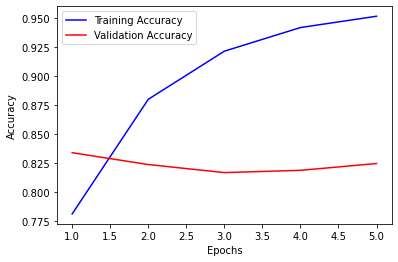

In [11]:
# Évolution de l'accuracy durant l'entraînement
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(np.arange(1,len(training_history.history['acc'])+1,1),
         training_history.history['acc'],label='Training Accuracy',color='blue')
plt.plot(np.arange(1,len(training_history.history['val_acc'])+1,1),
         training_history.history['val_acc'],label='Validation Accuracy',color='red')
plt.legend()
plt.show()


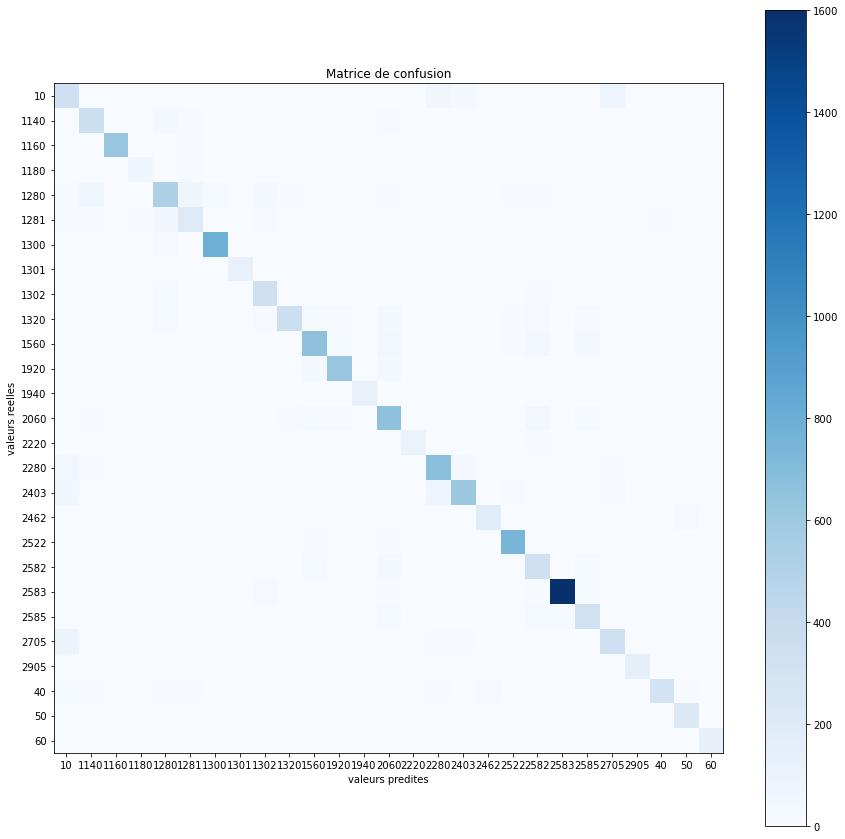

In [14]:
# Prédictions sur le jeu d'entraînement
valid_generator = trainGenerator(data=data_valid,X=X_valid,y='class',batch_size=1,seed=123)
valid_pred_class = model.predict_generator(valid_generator,steps=len(data_valid))

# Correspondance entre les indices et les classes
index_classe = np.arange(27)
list_classe = ['10', '1140', '1160', '1180', '1280', '1281', '1300', '1301', '1302', '1320', '1560', '1920', '1940', '2060', '2220', '2280', '2403', '2462', '2522', '2582', '2583', '2585', '2705', '2905', '40', '50', '60']

# Remplacement des indices par les noms des classes
y_true = data_valid['class']
valid_pred = pd.Series(valid_pred_class.argmax(axis=1))
valid_pred = valid_pred.replace(to_replace=index_classe,value=list_classe)

# Matrice de confusion
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(y_true,valid_pred)

classes = np.unique(y_true)

plt.figure(figsize=(15,15))
plt.imshow(cnf_matrix, interpolation='nearest',cmap='Blues')
plt.title("Matrice de confusion")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
plt.xlabel('valeurs predites')
plt.ylabel('valeurs reelles');

In [15]:
# Scores
from sklearn.metrics import classification_report
print(classification_report(y_true,valid_pred))

              precision    recall  f1-score   support

          10       0.57      0.65      0.61       507
        1140       0.71      0.80      0.75       434
        1160       0.98      0.96      0.97       643
        1180       0.74      0.59      0.65       124
        1280       0.75      0.66      0.70       792
        1281       0.55      0.58      0.56       337
        1300       0.96      0.96      0.96       821
        1301       0.92      0.92      0.92       131
        1302       0.72      0.81      0.77       405
        1320       0.85      0.66      0.74       527
        1560       0.84      0.80      0.82       825
        1920       0.91      0.88      0.90       700
        1940       0.87      0.89      0.88       131
        2060       0.74      0.81      0.78       812
        2220       0.87      0.78      0.82       134
        2280       0.81      0.88      0.84       774
        2403       0.86      0.77      0.82       777
        2462       0.83    